In [2]:
import pandas as pd
import numpy as np
import os
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tusc5IntegralUtils import *
from Tusc5ImageUtils import *

[2024-09-30 19:08:28,302][INFO]: Connecting Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
[2024-09-30 19:08:28,571][INFO]: Connected Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Data

In [17]:
'''
Accepts data from the new image analysis
'''

raw_data_csv_name = '090324_IHC_images_new'
Cell_Results = pd.read_csv('raw_data_folder/' + raw_data_csv_name + '.csv')
Cell_Results['X_vals'] = Cell_Results['X_vals'].apply(ast.literal_eval) # Makes it so cells containing lists are identifiable as lists by pandas
Cell_Results['Y_vals'] = Cell_Results['Y_vals'].apply(ast.literal_eval)
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip
0,"(14152, 15257, 17443, 19937, 23710, 29877, 388...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False
1,"(13820, 14917, 16133, 16977, 19591, 22441, 283...",5,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False
2,"(7424, 8554, 9730, 11578, 13716, 17834, 25161,...",5,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False
3,"(124, 168, 382, 629, 1290, 2778, 5222, 7744, 1...",5,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False
4,"(6652, 7067, 7968, 9222, 11371, 13519, 17178, ...",6,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,False,18.849620,False


## DJID_GEN_Eye Merge

In [18]:
'''
'DJID_GEN_EYES.csv' contains DJIDs which connect DJIDs to genotype and which eye was in the experimental or control group

This code chunk merges that dataframe with Cell_Results


Takes into consideration if file_name has variations on eye types (e.g. RA, LD)
'''

Recorded_Info = pd.read_csv('DJID_GEN_EYES_DURATION.csv')
merged_df = pd.merge(Cell_Results, Recorded_Info[['DJID', 'Genotype', 'Experimental Eye', 'Control Eye', 'Time_Condition']], on='DJID', how='left')

merged_df.loc[merged_df['Eye'] == merged_df['Experimental Eye'], 'Group_Type'] = 'Experimental'
merged_df.loc[merged_df['Eye'] == merged_df['Control Eye'], 'Group_Type'] = 'Control'

# Special case Group_Type assignment for time_series_old_batch_new
merged_df.loc[merged_df['Eye'].str[-1].isin(['A', 'B']), 'Group_Type'] = 'Experimental'
merged_df.loc[merged_df['Eye'].str[-1].isin(['C', 'D']), 'Group_Type'] = 'Control'


Cell_Results = merged_df.drop(columns=['Experimental Eye', 'Control Eye'])

if sum(merged_df['Group_Type'].isna()) > 0:
    print('WARNING: There is an NaN value in the Group_Type column. Check the file_name and DJID_GEN_DURATION.csv for errors')

Cell_Results.loc[Cell_Results['Genotype'] == 'wildtype', 'eGFP_Value'] = False # Making sure wildtype retinas do not have false positive eGFP cells

Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type
0,"(14152, 15257, 17443, 19937, 23710, 29877, 388...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental
1,"(13820, 14917, 16133, 16977, 19591, 22441, 283...",5,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental
2,"(7424, 8554, 9730, 11578, 13716, 17834, 25161,...",5,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental
3,"(124, 168, 382, 629, 1290, 2778, 5222, 7744, 1...",5,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental
4,"(6652, 7067, 7968, 9222, 11371, 13519, 17178, ...",6,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,False,18.849620,False,homo,30.0,Experimental


In [19]:
print('STATS BEFORE FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)

print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS BEFORE FILTER
##################################################
DJID: [3558 3588 3606 3607 3608 3653 3655 3657]
in_rip: [False  True]
Group_type: ['Experimental' nan 'Control']
Time Conditions: [30. nan 90. 60. 15.]
Genotype: ['homo' nan 'het']
##################################################
DJID
3558     46.0
3588      0.0
3606     90.0
3607     37.0
3608    169.0
3653    308.0
3655     65.0
3657    101.0
Name: Time_Condition, dtype: float64
##################################################


## Birth Data Merge


In [20]:
'''
Fetching a table to connect DJID to mouse age
Then merging that table to Cell_Results

'''

# DJ query and fetch
init_query = sln_animal.Animal.proj('dob', 'sex') * sln_animal.AnimalEvent * sln_animal.Deceased
birth_data = init_query.proj('dob', 'sex', 'date').fetch(format = 'frame')

# Reseting index and renaming columns
birth_data = birth_data.reset_index().drop(columns = ['event_id'])
birth_data = birth_data.rename(columns = {'animal_id': 'DJID', 'dob': 'birth', 'date': 'death'})

# Changing variables to date time vars
birth_data['birth'] = pd.to_datetime(birth_data['birth'])
birth_data['death'] = pd.to_datetime(birth_data['death'])

# Calculate the difference in days
birth_data['Age_Days'] = (birth_data['death'] - birth_data['birth']).dt.days

# Convert days to months (approximately, assuming ~30.44 days in a month)
birth_data['Age_Months'] = round(birth_data['Age_Days'] / 30.44,1)

# Merge
Cell_Results = Cell_Results.merge(birth_data, how = 'left', on = 'DJID')
Cell_Results = Cell_Results.drop(columns = ['birth', 'death', 'Age_Days'])
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months
0,"(14152, 15257, 17443, 19937, 23710, 29877, 388...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3
1,"(13820, 14917, 16133, 16977, 19591, 22441, 283...",5,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3
2,"(7424, 8554, 9730, 11578, 13716, 17834, 25161,...",5,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3
3,"(124, 168, 382, 629, 1290, 2778, 5222, 7744, 1...",5,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3
4,"(6652, 7067, 7968, 9222, 11371, 13519, 17178, ...",6,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,False,18.849620,False,homo,30.0,Experimental,Female,2.3


## Slice Separation and ID generation

In [21]:
'''
1) Adds a column to the dataframe which contains the z-stack slice seperation value

2) Adds a cell id

'''
Cell_Results['Slice_Seperation'] = Cell_Results['X_vals'].apply(lambda x: x[1]-x[0])

Cell_Results['Cell'] = Cell_Results.groupby(['file_name', 'mask_id']).ngroup()

In [22]:
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell
0,"(14152, 15257, 17443, 19937, 23710, 29877, 388...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3,0.15,0
1,"(13820, 14917, 16133, 16977, 19591, 22441, 283...",5,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3,0.15,0
2,"(7424, 8554, 9730, 11578, 13716, 17834, 25161,...",5,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3,0.15,0
3,"(124, 168, 382, 629, 1290, 2778, 5222, 7744, 1...",5,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,True,22.692926,False,homo,30.0,Experimental,Female,2.3,0.15,0
4,"(6652, 7067, 7968, 9222, 11371, 13519, 17178, ...",6,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3558R0_GLUT1_WGA_0002,3558,R0,False,18.849620,False,homo,30.0,Experimental,Female,2.3,0.15,1


Stain: DAPI, Detected peaks at indices: [23]
Stain: eGFP, Detected peaks at indices: [23]
Stain: WGA, Detected peaks at indices: [9]
Stain: GluT1, Detected peaks at indices: [13]


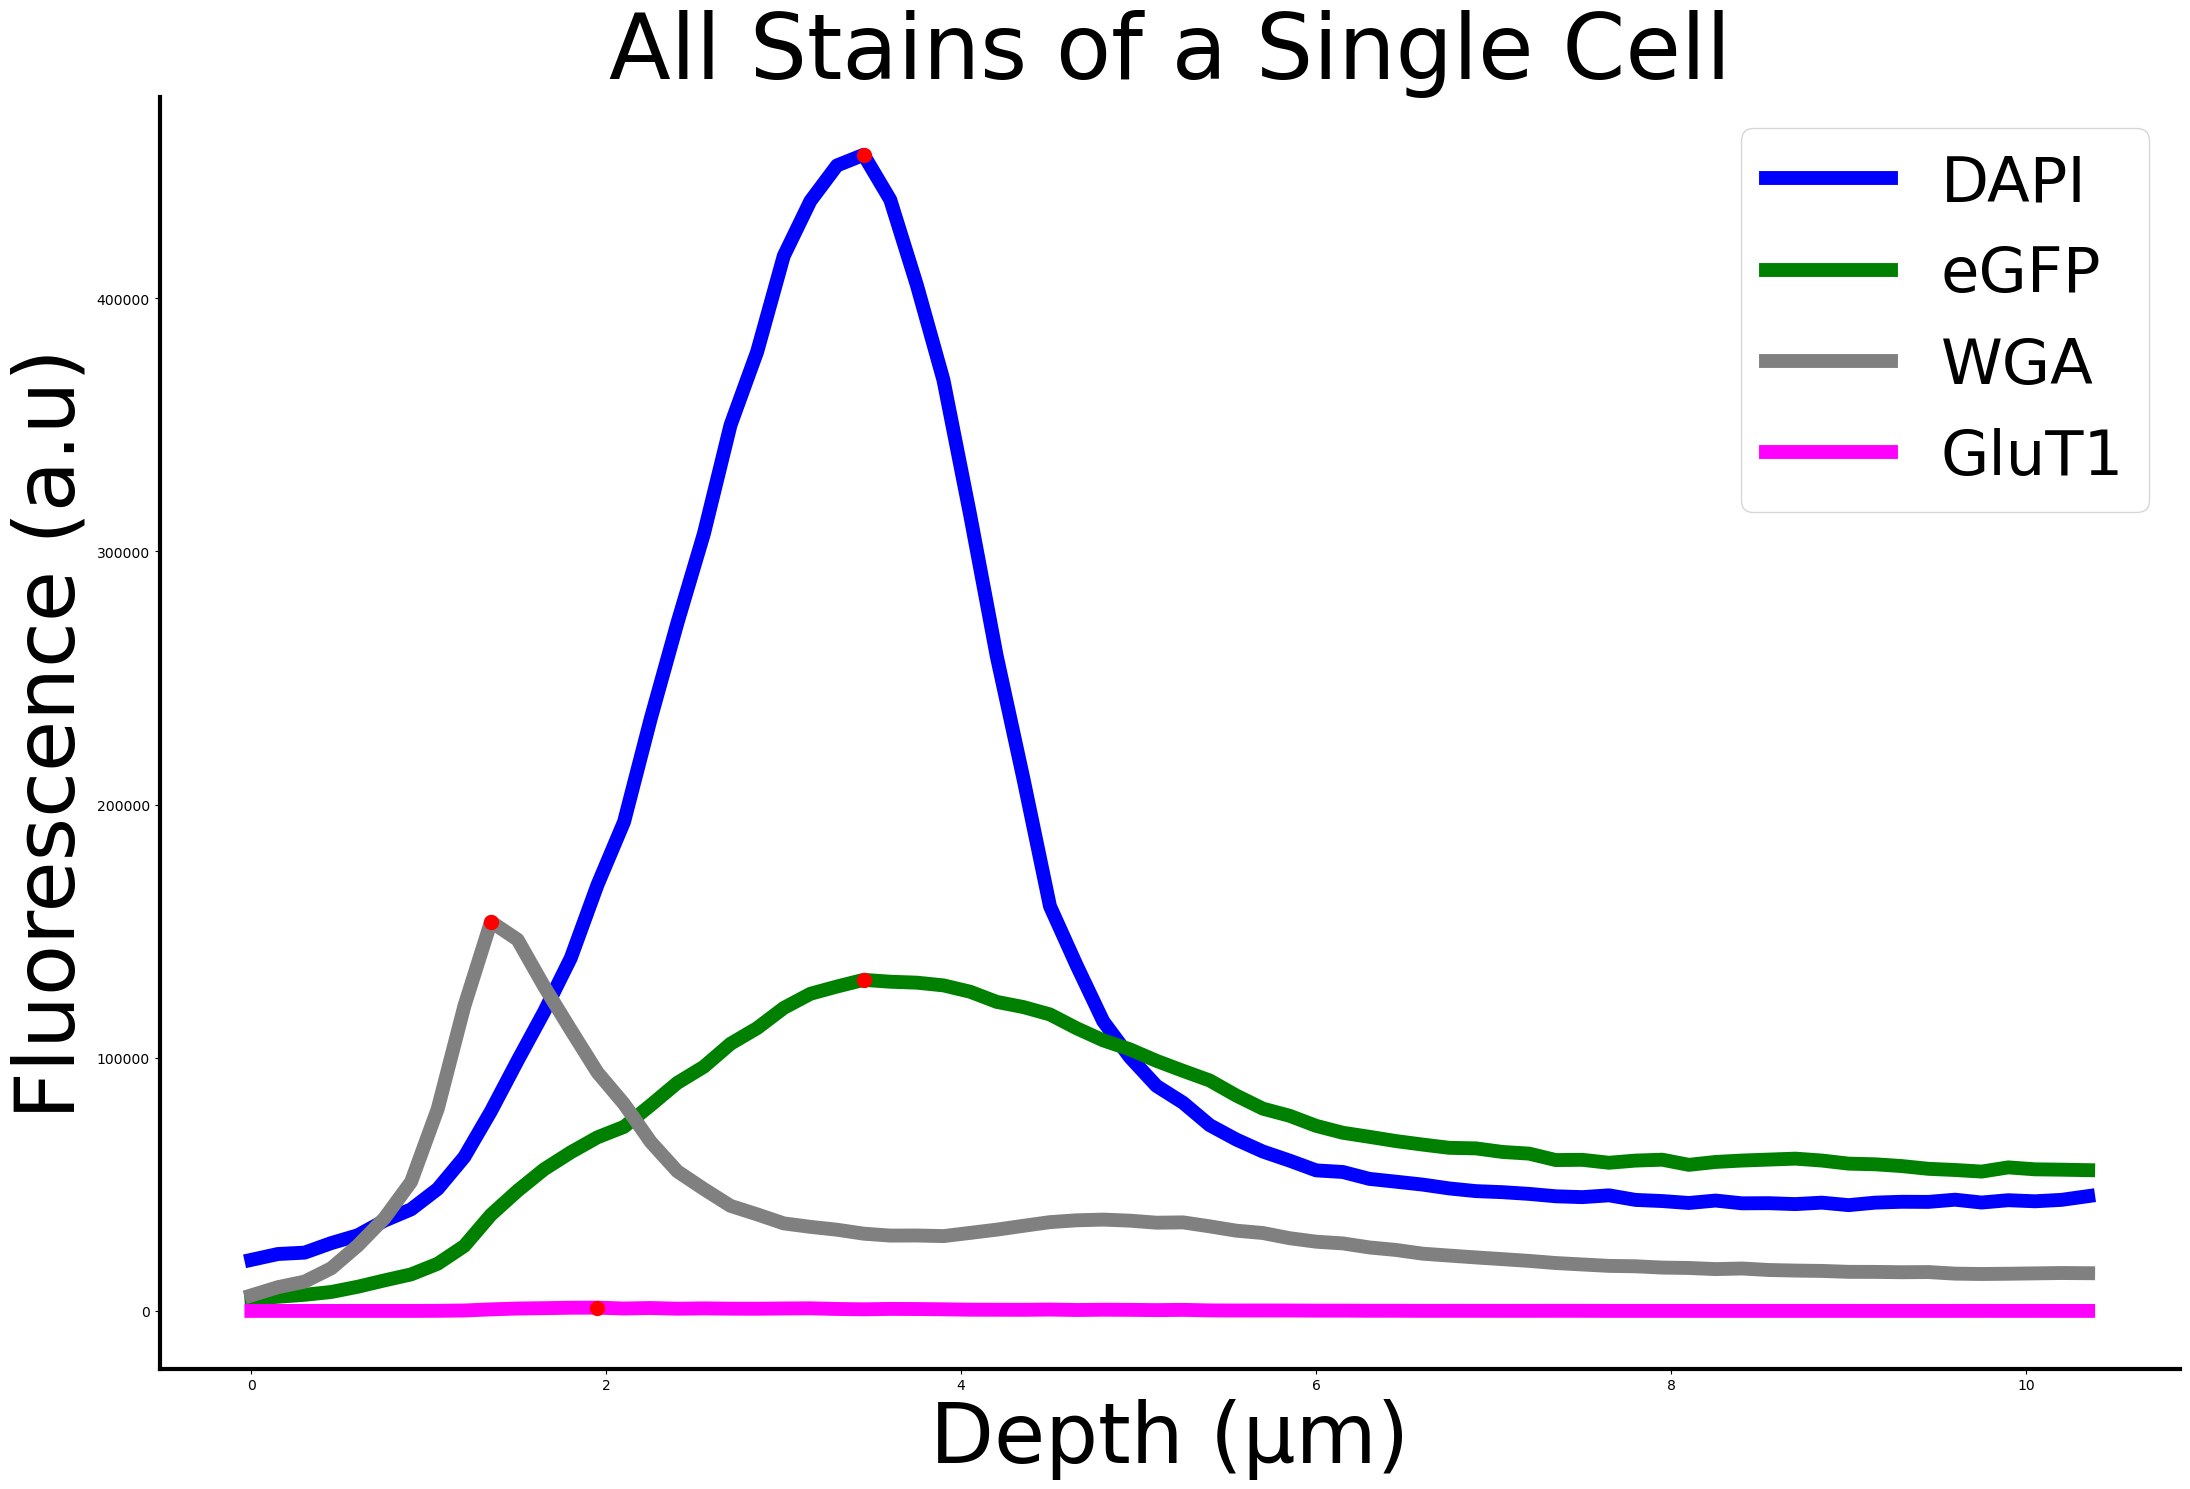

In [23]:
plot_single_cell(Cell_Results.query('Cell == 474'), prominence= 1000, distance = 70)

In [24]:
def WGA_Peaks_Finder_V2(dataframe, prom_val: int = 1000):
    '''
    This function finds WGA peaks before and after the first DAPI peak in each cell.

    It filters out cells with multiple DAPI peaks and leaves cells without a DAPI peak as NaN for the DAPI peak index.

    Returns:
    - 'WGA_Middle_Indices' as a tuple of (WGA peak before DAPI, WGA peak after DAPI), with None if a peak is not found.
    - 'DAPI_peak_index' as NaN if no valid DAPI peak is found, or as a single integer if exactly one DAPI peak exists.
    '''
    
    # Function to find WGA peaks for each cell (via .groupby)
    def filter_peaks_in_cell(cell_df):
        # Filter rows where Stain is 'WGA' and 'DAPI'
        df_WGA = cell_df.loc[cell_df['Stain'] == 'WGA']
        df_DAPI = cell_df.loc[cell_df['Stain'] == 'DAPI']

        # Find slice separation
        slice_separation = df_WGA.iloc[0]['Slice_Seperation']

        # Set distance where only one DAPI peak exists
        DAPI_min_distance = int(12 / slice_separation)
        WGA_min_distance = int(1.05 / slice_separation) 
        
        # Finding peaks for DAPI and WGA
        DAPI_peak_indicies = find_peaks(df_DAPI['Y_vals'].iloc[0], prominence=prom_val, distance=DAPI_min_distance)[0]
        WGA_peak_indicies = find_peaks(df_WGA['Y_vals'].iloc[0], prominence=prom_val, distance=WGA_min_distance)[0]

        # Initialize variables for WGA peaks before and after DAPI peak
        first_WGA_before_DAPI = np.NaN
        first_WGA_after_DAPI = np.NaN

        # If we have exactly one DAPI peak, proceed with finding WGA peaks before and after
        if isinstance(DAPI_peak_indicies, (np.ndarray, list)) and len(DAPI_peak_indicies) == 1:
            DAPI_peak_index = int(DAPI_peak_indicies[0])  # Convert to int explicitly to ensure it's an int

            # Iterate over WGA peaks to find the first before and after the DAPI peak
            for peak in WGA_peak_indicies:
                if peak < DAPI_peak_index:
                    first_WGA_before_DAPI = peak  # Update with the latest WGA peak before DAPI
                elif peak > DAPI_peak_index and np.isnan(first_WGA_after_DAPI):
                    first_WGA_after_DAPI = peak  # First WGA peak after DAPI, break the loop
                    break
        else:
            # If there are no DAPI peaks or multiple DAPI peaks, set DAPI_peak_index to NaN
            DAPI_peak_index = np.NaN

        # Return both WGA peaks and the DAPI peak index (as an integer or NaN)
        return [first_WGA_before_DAPI, first_WGA_after_DAPI], DAPI_peak_index

    # Apply the peak finder function across cells grouped by 'Cell'
    grouped = dataframe.groupby('Cell')
    
    # Apply the filtering function to each group of cells and unpack the results
    grouped_results = grouped.apply(lambda cell: pd.Series(filter_peaks_in_cell(cell))).reset_index()
    
    # Rename the columns where we stored the list of WGA peaks and DAPI peaks
    grouped_results = grouped_results.rename(columns={0: 'WGA_Middle_Indices', 1: 'DAPI_peak_index'})
    
    # Calculate the length between the two peaks and add a Length column
    grouped_results['Length'] = grouped_results['WGA_Middle_Indices'].apply(
        lambda x: (x[1] - x[0]) * dataframe['Slice_Seperation'].iloc[0] 
        if not np.isnan(x[0]) and not np.isnan(x[1]) else np.NaN
    )

    # Merge the peak indices and DAPI peaks back into the original DataFrame
    result_df = pd.merge(dataframe, grouped_results[['Cell', 'WGA_Middle_Indices', 'DAPI_peak_index', 'Length']], on='Cell', how='left')

    return result_df.copy()

Cell_Results = WGA_Peaks_Finder_V2(Cell_Results)

In [25]:
# Removed filter_out_bad_peaks function

def filter_out_unclear_DAPI(dataframe):
    '''
    This function filters cells from a DataFrame based solely on the presence of a clear DAPI peak.
    
    Criteria:
    1. The cell must have a clear DAPI peak, either as a single value or as the first element in a list.
    
    Parameters:
    - dataframe: Input DataFrame with a 'DAPI_peak_index' column representing DAPI peak positions.

    Returns:
    - A filtered DataFrame retaining only cells with a clear DAPI peak.
    '''
    
    # Helper function to check if there is a valid DAPI peak
    def get_first_DAPI_peak(DAPI_peak):
        if pd.isna(DAPI_peak):
            return None  # No valid DAPI peak
        else:
            return DAPI_peak  # Single DAPI peak as an integer
    
    # Helper function to validate if a cell has a clear DAPI peak
    def is_cell_valid(row):
        DAPI_peak = get_first_DAPI_peak(row['DAPI_peak_index'])
        return DAPI_peak is not None  # The cell is valid if there's a valid DAPI peak
    
    # Identify the invalid cells
    invalid_cells_dataframe = dataframe[~dataframe.apply(is_cell_valid, axis=1)].reset_index(drop=True)
    
    # Print the IDs of the cells that are filtered out
    if not invalid_cells_dataframe.empty:
        print("Filtered out cells:", invalid_cells_dataframe['Cell'].unique().tolist())
    else:
        print("No cells were filtered out.")
    
    # Filter out the invalid cells and return the valid cells
    filtered_cells_dataframe = dataframe[dataframe.apply(is_cell_valid, axis=1)].reset_index(drop=True)
    
    return filtered_cells_dataframe.copy()

Cell_Results = filter_out_unclear_DAPI(Cell_Results)

Cell_Results['DAPI_peak_index'] = pd.to_numeric(Cell_Results.DAPI_peak_index, downcast='integer') # Changing column to int

Filtered out cells: [243, 456, 568]


In [26]:
# Helper function: Returns cells with only one peak
def filter_for_single_peak(dataframe):
    '''
    Returns:
    - A filtered DataFrame retaining only cells with one WGA peak before the DAPI peak.
    '''
    
    # Helper function to check if there is a valid DAPI peak
    def get_first_DAPI_peak(DAPI_peak):
        if isinstance(DAPI_peak, list) or isinstance(DAPI_peak, np.ndarray):
            if len(DAPI_peak) > 0:
                return DAPI_peak[0]  # If DAPI peaks are in a list, take the first one
            else:
                return None  # Empty list/array, no valid DAPI peak
        elif pd.isna(DAPI_peak):
            return None  # No valid DAPI peak
        else:
            return DAPI_peak  # Single DAPI peak as an integer
    
    # Helper function to validate if a cell meets the criteria
    def is_cell_valid(row):
        WGA_peaks = row['WGA_Middle_Indices']
        DAPI_peak = get_first_DAPI_peak(row['DAPI_peak_index'])

        # Ensure we have a valid DAPI peak
        if DAPI_peak is None:
            return False

        # Check that there's exactly one valid WGA peak before the DAPI peak
        WGA_before_DAPI = WGA_peaks[0]  # First WGA peak (before DAPI)
        
        if pd.isna(WGA_before_DAPI) or WGA_before_DAPI >= DAPI_peak:
            return False  # There must be one WGA peak before the DAPI peak
        
        # The second WGA peak must be NaN, indicating there is only one peak
        WGA_after_DAPI = WGA_peaks[1] if len(WGA_peaks) > 1 else np.NaN
        if not pd.isna(WGA_after_DAPI):
            return False  # If there's a second WGA peak, reject the cell

        return True

    # Filter out the invalid cells and return the valid cells
    filtered_cells_dataframe = dataframe[dataframe.apply(is_cell_valid, axis=1)].reset_index(drop=True)
    
    return filtered_cells_dataframe

#'''
#Quick visualizations to see cells that have a single peak or in a rip
#'''

#example_frame = filter_for_single_peak(Cell_Results)
#rand_cell = np.random.choice(example_frame.Cell.unique())
#plot_single_cell(example_frame.query('Cell == @rand_cell'))

#rand_cell = np.random.choice(Cell_Results.query('in_rip == True').Cell.unique())
# plot_single_cell(Cell_Results.query('Cell == @rand_cell'), prominence = 1000, distance = 7)

## Filters (Retired 9/10/24)

In [27]:
'''
Goes through each cell in Cell_Results and calculates peaks

Prominence = 25 was chosen as it experimentally retained the most number of good cells.

'''

# Peak Filter

print(f'Original number of Cells: {len(Cell_Results)/4}')

remove_list = []

for cell_number in Cell_Results['Cell'].unique():
    
    CR_Query = Cell_Results.query('Cell == @cell_number').copy()

    slice_seperation = CR_Query.iloc[0]['Slice_Seperation']

    WGA_min_distance = int(2.25 / slice_seperation) # peaks must be 2.25 microns away from eachother
    DAPI_min_distance = int(10 / slice_seperation)
    
    index_max = len(CR_Query.iloc[0]['X_vals'])

    WGA_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0]
    DAPI_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0]

    peaks_WGA, _ = find_peaks(WGA_Y_vals, prominence= 25, distance = WGA_min_distance)
    peaks_DAPI, _ = find_peaks(DAPI_Y_vals, prominence= 25, distance = DAPI_min_distance)

    '''
    WGA Filters

    '''
    
    # 1) Remove if less than two peaks
    if len(peaks_WGA) < 2:
        remove_list.append(cell_number)
        continue
    

    if peaks_WGA[1] != peaks_WGA[-1] and WGA_Y_vals[peaks_WGA[-1]] > WGA_Y_vals[peaks_WGA[1]]:
        remove_list.append(cell_number)
        continue

    # '''
    # DAPI Filters
    # '''

    if len(peaks_DAPI) < 1:
        remove_list.append(cell_number)
        continue

    elif len(peaks_DAPI) == 1 and peaks_DAPI[0] > peaks_WGA[0] and peaks_DAPI[0] < peaks_WGA[1]:
        pass

    if peaks_DAPI[0] != peaks_DAPI[-1] and DAPI_Y_vals[peaks_DAPI[-1]] > DAPI_Y_vals[peaks_DAPI[1]]:
        remove_list.append(cell_number)

# Removing undesirable cells from main list
# remove_list = np.unique(remove_list)
# Cell_Results = Cell_Results[~Cell_Results['Cell'].isin(remove_list)]

# print(f'Remaining Cells after Filter: {len(Cell_Results)/4}')
# print(f'Cell Numbers Removed {remove_list}, count : {len(remove_list)}')

Original number of Cells: 850.0


In [28]:
print('STATS AFTER FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)
print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS AFTER FILTER
##################################################
DJID: [3558 3588 3606 3607 3608 3653 3655 3657]
in_rip: [False  True]
Group_type: ['Experimental' nan 'Control']
Time Conditions: [30. nan 90. 60. 15.]
Genotype: ['homo' nan 'het']
##################################################
DJID
3558     46.0
3588      0.0
3606     90.0
3607     37.0
3608    168.0
3653    306.0
3655     65.0
3657    101.0
Name: Time_Condition, dtype: float64
##################################################


## eGFP Finder (Retired when Image Analysis V2 released)

In [29]:
# # eGFP finder
# eGFP_filtered = []
# remove_from_eGFP = []

# for cell_number in Cell_Results['Cell'].unique():

#     CR_Query = Cell_Results.query('Cell == @cell_number').copy()

#     slice_seperation = CR_Query.iloc[0]['Slice_Seperation']
#     DAPI_min_distance = int(10 / slice_seperation)

#     DAPI_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0], prominence= 25, distance = DAPI_min_distance)
#     DAPI_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'DAPI', 'Y_vals'].iloc[0])[DAPI_idx[0]]

#     # eGFP peak needs to be at least half of DAPI peak to be considered eGFP positive
#     eGFP_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'eGFP']['Y_vals'].iloc[0], prominence= 100, distance = 10, height = int(DAPI_peak_val/2))
#     eGFP_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'eGFP', 'Y_vals'].iloc[0])[eGFP_idx]

#     WGA_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0], prominence= 25)
#     WGA_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'WGA', 'Y_vals'].iloc[0])[WGA_idx]

#     if len(eGFP_peak_val) == 1:

#         # If eGFP peak is not within WGA peaks, cell is not considered eGFP positive
#         if eGFP_idx < WGA_idx[0] or eGFP_idx > WGA_idx[1]:
#             remove_from_eGFP.append(cell_number)
        
#         # If eGFP is not at least 1/2 the size of 
#         if eGFP_peak_val > WGA_peak_val[1]/2:
#             eGFP_filtered.append(cell_number)


# eGFP_filtered = list(set(eGFP_filtered))
# eGFP_filtered = sorted([i for i in eGFP_filtered if i not in remove_from_eGFP])

# print(f'Cells with eGFP: {eGFP_filtered}, count: {len(eGFP_filtered)}')

# # Labeling Cells T5 Positive or Negative
# Cell_Results['T5'] = 'Negative'
# Cell_Results.loc[Cell_Results['Cell'].isin(eGFP_filtered), 'T5'] = 'Positive'

In [30]:
# # Comparison between
# positive_old_identifier = np.array(eGFP_filtered)
# positive_new_identifier = Cell_Results.loc[Cell_Results['eGFP_Value'] == True].Cell.unique()
# print('Number of cells in old eGFP finder', len(positive_old_identifier))
# print('Number of cells in new eGFP finder', len(positive_new_identifier))
# print('Percent of old cells from old eGFP finder in new eGFP finder:', np.isin(positive_old_identifier, positive_new_identifier).sum()/ len(np.isin(positive_old_identifier, positive_new_identifier)) * 100, '%')



Number of cells in old eGFP finder 4
Number of cells in new eGFP finder 226
Percent of old cells from old eGFP finder in new eGFP finder: 75.0 %


## Summary of Cell_Results

In [31]:
'''
Sanity Check


'''

print('Genotype', Cell_Results['Genotype'].unique())
print('T5 Labelling', Cell_Results['Stain'].unique())
print('eGFP Types', Cell_Results['eGFP_Value'].unique())

print('\n')
print('###'*12)
print('\n')

'''
Summary of mouse information
'''

def extract_before_underscore(input_string):
    parts = input_string.split("_", 1)
    if len(parts) > 1:
        return parts[0]
    
eyes = Cell_Results['file_name'].apply(extract_before_underscore).unique()

def extract_first_four_integers(input_string):
    # Find all substrings of consecutive digits
    integers = re.findall(r'\d+', input_string)
    
    # Convert the found substrings into integers
    integers = [int(i) for i in integers]
    
    # Return the first four integers
    return integers[:4][0]

animals = list(map(extract_first_four_integers, eyes))
animals = pd.Series(animals).unique() # Extracting the unqiue values

left = 0
right = 0

for i in eyes:
    if 'R' in i:
        right += 1
    if 'L' in i:
        left +=1

positive_count = Cell_Results['eGFP_Value'].value_counts()[True]/4
total = (len(Cell_Results))/4


###
print(f'Number of mice: {len(animals)}')
print(f'Mice DJIDs: {animals}')
print(f'Number of eyes: {len(eyes)}, Left = {left} R = {right}')

###
print('\n')
print('###'*12)
print('\n')

###
print('Number of Cells', Cell_Results['Cell'].count()/4)
print('eGFP Positive', (Cell_Results.groupby('eGFP_Value').size()/4)[True])
print('eGFP Negative', (Cell_Results.groupby('eGFP_Value').size()/4)[False])
print('Positive over Total Percentage', positive_count/total*100)

Genotype ['homo' nan 'het']
T5 Labelling ['DAPI' 'eGFP' 'WGA' 'GluT1']
eGFP Types [ True False]


####################################


Number of mice: 8
Mice DJIDs: [3558 3588 3606 3607 3608 3653 3655 3657]
Number of eyes: 8, Left = 1 R = 7


####################################


Number of Cells 850.0
eGFP Positive 226.0
eGFP Negative 624.0
Positive over Total Percentage 26.588235294117645


In [32]:
Cell_Results.columns

Index(['Y_vals', 'mask_id', 'Stain', 'X_vals', 'file_name', 'DJID', 'Eye',
       'eGFP_Value', 'eGFP_Raw_Intensity', 'in_rip', 'Genotype',
       'Time_Condition', 'Group_Type', 'sex', 'Age_Months', 'Slice_Seperation',
       'Cell', 'WGA_Middle_Indices', 'DAPI_peak_index', 'Length'],
      dtype='object')

In [33]:
Cell_Results.groupby(['Genotype','DJID','sex'])['Age_Months'].unique()

Genotype  DJID  sex   
het       3607  Male      [3.0]
          3608  Male      [3.0]
          3655  Female    [2.1]
          3657  Female    [2.1]
homo      3558  Female    [2.3]
          3606  Male      [2.8]
          3653  Male      [1.9]
Name: Age_Months, dtype: object

# Calculations

## Defining Functions

In [34]:
# RETIRED
# WGA_Peaks_Finder is retired for WGA_Peaks_Finder_V2

'''
Function: Calculating WGA Peaks

Creates columns: WGA_Middle_Indices, Length (um)

'''

def WGA_Peaks_Finder(dataframe, prom_val:int = 25):

    # Function to find WGA peaks for each cell (via .groupby)
    def find_peaks_in_cell(cell_df):
        # Filter rows where Stain is 'WGA'
        df_WGA = cell_df.loc[cell_df['Stain'] == 'WGA']
        
        slice_seperation = df_WGA.iloc[0]['Slice_Seperation']
        WGA_min_distance = int(2.25 / slice_seperation) 
        
        WGA_peak_indicies = find_peaks(df_WGA['Y_vals'].iloc[0], prominence = prom_val, distance = WGA_min_distance)[0]


        return WGA_peak_indicies

    # Apply the peak finder function across cells grouped by 'Cell'
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first().iloc[0]

    grouped_WGA_indices = grouped.apply(find_peaks_in_cell).reset_index().rename(columns={0: 'WGA_Middle_Indices'})    # Reset index to flatten the DataFrame and rename



    grouped_WGA_indices['Length'] = grouped_WGA_indices['WGA_Middle_Indices'].apply(lambda x: (x[1] - x[0]) * slice_separation)

    #Merge the peak indices back into the original DataFrame
    result_df = pd.merge(dataframe, grouped_WGA_indices, on='Cell', how='left')

    return result_df


In [35]:
'''
Function: Calculates "Top" and "Bottom" INDICES to be used for integral boundaries

Creates columns: WGA_Top_Indices, WGA_Bottom_Indices
'''

def Top_Bottom_Indices_V2(dataframe, microns_extension: float = 1.5):
    '''
    Function: Calculates "Top" and "Bottom" INDICES to be used for integral boundaries.

    V2: IF the bottom WGA is nan, returns None for bottom indicies 
    
    Creates columns: WGA_Top_Indices, WGA_Bottom_Indices
    '''
    
    # Grouping / Getting Slice Separation / Calculating peaks
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first()
    max_idx = grouped['X_vals'].apply(lambda x: len(x.iloc[0]))  # Length of each cell's X_vals
    
    first_peaks = grouped['WGA_Middle_Indices'].apply(lambda x: x.iloc[0] if len(x) > 0 else [np.nan, np.nan])

    # Calculate index offset for each cell based on the slice separation
    index_offset = (microns_extension / slice_separation).fillna(0).astype(int)

    # Separate the peak indices
    l_middle = first_peaks.apply(lambda x: x[0] if len(x) > 0 else np.nan)
    r_middle = first_peaks.apply(lambda x: x[1] if len(x) > 1 else np.nan)

    # Calculate modified indices
    l_top = np.maximum(l_middle - index_offset, 0)  # Ensuring indices do not go below 0
    r_bot = r_middle + index_offset

    # If the bottom WGA peak is not found, set r_middle and r_bot to None
    r_middle = r_middle.apply(lambda x: None if pd.isna(x) else x)
    r_bot = r_bot.apply(lambda x: None if pd.isna(x) else x)

    # Creating DataFrame for merging
    idx_df = pd.DataFrame({
        'Cell': grouped.size().index,  # Assures alignment with group keys
        'WGA_Top_Indices': list(zip(l_top, l_middle)),
        'WGA_Bottom_Indices': list(zip(r_middle, r_bot))
    })

    # Merge adjusted index data back into the original DataFrame
    result_df = pd.merge(dataframe, idx_df, on='Cell', how='left')

    return result_df

In [36]:

def TopMidBot_Integrals_V2(dataframe):
    '''
    Function: Calculates "Top", "Middle", "Bottom" INTEGRALS

    V2: Returns None for Middle and Top integrals if right WGA peak is nan

    Creates columns: Middle_Integral, Top_Integral, Bottom_Integral
    '''
    
    # Allows you to calculate integrals through .apply()
    def integral_calculator(y_vals, indices, integral_section: str = 'Middle'):
        """
        This function calculates the sum of y-values within a specified range (top, middle, or bottom).
        If the indices are None or invalid, it returns None.
        """
        # Check if indices are None or contain NaN values
        if indices is None or pd.isna(indices[0]) or pd.isna(indices[1]):
            return None
        
        # Ensure the indices are integers (or convert them to integers)
        try:
            start_idx = int(indices[0])
            end_idx = int(indices[1])
        except (ValueError, TypeError):
            return None
        
        # Adjust indices to stay within bounds
        start_idx = max(start_idx, 0)  # If start index is less than 0, set to 0
        end_idx = min(end_idx, len(y_vals))  # If end index is greater than length of y_vals, set to max length

        # Ensure the range makes sense (start_idx should not be greater than end_idx)
        if start_idx >= end_idx:
            return None
        
        # Otherwise, safely slice the array using the adjusted indices
        return np.sum(np.array(y_vals)[start_idx:end_idx])

    # Iterate over 'Middle', 'Top', and 'Bottom' sections to compute integrals for each
    for section in ['Middle', 'Top', 'Bottom']:
        # Use apply to calculate the integrals and store them in new columns
        dataframe[f'{section}_Integral'] = dataframe.apply(
            lambda x: integral_calculator(x['Y_vals'], x[f'WGA_{section}_Indices'], integral_section=section), 
            axis=1
        )
    
    return dataframe

In [37]:
def Surface_Integrals_V2(dataframe):
    '''
    Function: Calculates "Top", "Bottom" INTEGRAL RATIOS

    V2: Returns None for bottom surface if right WGA peak isn't found

    # Calculating the ratio of Glut1 over WGA (normalization) 0.5 microns about the WGA peaks

    Creates columns: [WGA or GluT1]_[Top or Bot]_Surface_Integral
    '''

    # Initialize a list to store results dataframes for each group
    results = []

    # Group by 'Cell' and process each group
    for (cell, group) in dataframe.groupby('Cell'):
        # Filter for WGA and GluT1 stains
        df_WGA = group.loc[group['Stain'] == 'WGA']
        df_GluT1 = group.loc[group['Stain'] == 'GluT1']

        peak_indices = df_WGA['WGA_Middle_Indices'].iloc[0]
        x_vals = df_WGA['X_vals'].iloc[0]

        # Compute slice separation and radius offset
        slice_separation = group['Slice_Seperation'].iloc[0]
        radius = 0.5
        idx_offset = int(radius / slice_separation)  # Ensure idx_offset is an integer

        # Define borders based on peak indices and radius offset, with checks for missing peaks
        if not pd.isna(peak_indices[0]):  # Check if top peak is valid
            top_lborder = max(int(peak_indices[0]) - idx_offset, 0)  # Ensure integer indices
            top_rborder = min(int(peak_indices[0]) + idx_offset, len(x_vals))
        else:
            top_lborder = None
            top_rborder = None

        # Bottom indices check (return None if the bottom peak is not found)
        if not pd.isna(peak_indices[1]):  # Check if bottom peak is valid
            bottom_lborder = max(int(peak_indices[1]) - idx_offset, 0)  # Ensure integer indices
            bottom_rborder = min(int(peak_indices[1]) + idx_offset, len(x_vals))
        else:
            bottom_lborder = None
            bottom_rborder = None

        # Calculate integrals for 'GluT1' and 'WGA'
        if top_lborder is not None and top_rborder is not None:
            top_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][top_lborder:top_rborder])
            top_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][top_lborder:top_rborder])
        else:
            top_surface_integral_GluT1 = None
            top_surface_integral_WGA = None

        if bottom_lborder is not None and bottom_rborder is not None:
            bottom_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder])
            bottom_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder])
        else:
            bottom_surface_integral_GluT1 = None
            bottom_surface_integral_WGA = None

        # Ratio calculations with checks for division by zero
        Top_G_over_W = top_surface_integral_GluT1 / top_surface_integral_WGA if top_surface_integral_WGA and top_surface_integral_WGA != 0 else None
        Bottom_G_over_W = (
            bottom_surface_integral_GluT1 / bottom_surface_integral_WGA 
            if bottom_surface_integral_WGA and bottom_surface_integral_WGA != 0 else None
        )

        # Append results as a DataFrame to list
        results.append(pd.DataFrame({
            'Cell': [cell],
            'GluT1_Top_Surface_Integral': [top_surface_integral_GluT1],
            'GluT1_Bot_Surface_Integral': [bottom_surface_integral_GluT1],
            'WGA_Top_Surface_Integral': [top_surface_integral_WGA],
            'WGA_Bot_Surface_Integral': [bottom_surface_integral_WGA],
            'Top_Surface_Ratio': [Top_G_over_W],
            'Bot_Surface_Ratio': [Bottom_G_over_W]
        }))

    # Concatenate all results into a single DataFrame
    results_df = pd.concat(results, ignore_index=True)

    # Merge adjusted index data back into the original DataFrame
    dataframe = dataframe.merge(results_df, on='Cell', how='left')
    
    return dataframe

In [38]:
"""
Function: Reshapes columns, so that each group has a column with '{Stain}_{Integral_Type}'. 4 x 3 = 12 columns are added
"""

def Reshape_Integrals(dataframe):

    # Make pivot table
    pivot_df = dataframe.pivot_table(
        index=['Cell'], 
        columns='Stain',
        values=['Middle_Integral', 'Top_Integral', 'Bottom_Integral'],
        aggfunc='first' 
    )

    # Flatten the multi-level column headers and format them
    pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns.values]

    pivot_df.reset_index(inplace=True) # Cell is a column used to merge 

    result_df = pd.merge(dataframe, pivot_df)

    return result_df

In [39]:
# NaNs are often placed as default over None. By returning None, it shows that it was on purpose.

def Replace_NaNs_With_None(dataframe):
    """
    Replaces all `NaN` values in a DataFrame with `None`, including `NaN` values inside lists and tuples.
    
    Returns:
    pd.DataFrame: A DataFrame where all `NaN` values have been replaced with `None`.
    """
    
    def replace_in_iterable(iterable):
        """Helper function to replace NaN with None inside a list or tuple."""
        return type(iterable)(None if pd.isna(item) else item for item in iterable)
    
    def replace_nans(item):
        """Replace NaN with None for individual elements, lists, or tuples."""
        if isinstance(item, (list, tuple)):
            return replace_in_iterable(item)
        elif pd.isna(item):
            return None
        else:
            return item
    
    # Apply the replace_nans function to each element in the DataFrame
    return dataframe.applymap(replace_nans)

In [40]:
Cell_Results_Calcs = Cell_Results.copy()

# These functions find indices
Cell_Results_Calcs = Top_Bottom_Indices_V2(Cell_Results_Calcs)

# These functions calculate integrals using the index boundaries
Cell_Results_Calcs = TopMidBot_Integrals_V2(Cell_Results_Calcs)
Cell_Results_Calcs = Reshape_Integrals(Cell_Results_Calcs)
Cell_Results_Calcs = Surface_Integrals_V2(Cell_Results_Calcs)
Cell_Results_Calcs = Replace_NaNs_With_None(Cell_Results_Calcs)

## Export

In [41]:
'''
Making new dataframe for export
- Keeps certain columns
- Renames columns
- Mapping column categories to new names (e.g. eGFP Positive -> 1)
'''

# Columns to Keep
keep_cols = ['DJID', 'Genotype', 'Eye', 'sex', 'Age_Months', 'eGFP_Value', 'Group_Type', 'in_rip', 'Length', 'Time_Condition',
             'GluT1_Top_Surface_Integral', 'GluT1_Bot_Surface_Integral', 'WGA_Top_Surface_Integral', 'WGA_Bot_Surface_Integral',
             'GluT1_Top_Integral', 'GluT1_Middle_Integral', 'GluT1_Bottom_Integral',
             'WGA_Top_Integral', 'WGA_Middle_Integral', 'WGA_Bottom_Integral', 'file_name']

# Columns to rename
renamed_cols = {'sex': 'Sex',
                'Length': 'Length_um',
                'in_rip': 'In_Rip',
                'Group_Type' :'Experimental_Condition'}

Export_df = Cell_Results_Calcs.groupby('Cell').first().loc[:, keep_cols].reset_index(drop = True)
Export_df = Export_df.rename(columns = renamed_cols)

# Remapping values
Export_df['eGFP_Value'] = Export_df['eGFP_Value'].astype(int)
Export_df['In_Rip'] = Export_df['In_Rip'].astype(int)

Exp_Con_map = {'Experimental': 'Light Flicker', 'Control': 'Dark'}
Export_df['Experimental_Condition'] = Export_df['Experimental_Condition'].map(Exp_Con_map)#.fillna(Export_df['Experimental_Condition'])


# Raphael 91024. Now invalid since NA values are allowed.
# # Checking for NA vals
# if Export_df.isna().sum().sum() > 0:
#     print('There are NA values, check for problems.')

Export_df

,DJID,Genotype,Eye,Sex,Age_Months,eGFP_Value,Experimental_Condition,In_Rip,Length_um,Time_Condition,...,GluT1_Bot_Surface_Integral,WGA_Top_Surface_Integral,WGA_Bot_Surface_Integral,GluT1_Top_Integral,GluT1_Middle_Integral,GluT1_Bottom_Integral,WGA_Top_Integral,WGA_Middle_Integral,WGA_Bottom_Integral,file_name
0,3558,homo,R0,Female,2.3,1,Light Flicker,0,1.65,30.0,...,62489.0,891445.0,1228659.0,133831.0,319225.0,51193.0,513768.0,1886160.0,1845299.0,3558R0_GLUT1_WGA_0002
1,3558,homo,R0,Female,2.3,0,Light Flicker,0,NaN,30.0,...,34975.0,NaN,695634.0,NaN,NaN,28382.0,NaN,NaN,1010165.0,3558R0_GLUT1_WGA_0002
2,3558,homo,R0,Female,2.3,1,Light Flicker,0,1.65,30.0,...,69968.0,985927.0,1601978.0,43351.0,167388.0,73880.0,605314.0,2373954.0,2482770.0,3558R0_GLUT1_WGA_0002
3,3558,homo,R0,Female,2.3,1,Light Flicker,0,2.40,30.0,...,45940.0,876008.0,1043940.0,132476.0,304721.0,45255.0,577655.0,2327646.0,1288611.0,3558R0_GLUT1_WGA_0002
4,3558,homo,R0,Female,2.3,1,Light Flicker,0,2.55,30.0,...,49092.0,1152058.0,1329145.0,90679.0,317555.0,42853.0,717938.0,3266380.0,1653107.0,3558R0_GLUT1_WGA_0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,3657,het,R,Female,2.1,0,Dark,0,NaN,30.0,...,NaN,417751.0,NaN,29432.0,NaN,NaN,151503.0,NaN,NaN,3657R_GLUT1_WGA_0001
845,3657,het,R,Female,2.1,0,Dark,0,1.65,30.0,...,88107.0,358808.0,199748.0,15421.0,140819.0,142680.0,143826.0,467252.0,266300.0,3657R_GLUT1_WGA_0001
846,3657,het,R,Female,2.1,0,Dark,0,NaN,30.0,...,NaN,641094.0,NaN,40129.0,NaN,NaN,237867.0,NaN,NaN,3657R_GLUT1_WGA_0001
847,3657,het,R,Female,2.1,1,Dark,0,2.85,30.0,...,130920.0,849032.0,432896.0,57414.0,851952.0,142577.0,244254.0,1880550.0,677809.0,3657R_GLUT1_WGA_0001


In [288]:
Export_df = Export_df.loc[Export_df['Genotype'] != 'wildtype']

processed_data_name_csv = #'het_time_processed_new'
Export_df.to_csv('processed_data_folder/' + processed_data_name_csv + '.csv', index = False)